# Import libs and data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import learning_curve
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC

from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import mean_squared_error

%matplotlib inline

In [2]:
df_12 = pd.read_csv('/home/nate/ds/metis/class_work/projects/clean_data/df_12_altered.csv')
df_13 = pd.read_csv('/home/nate/ds/metis/class_work/projects/clean_data/df_13_altered.csv')
df_14 = pd.read_csv('/home/nate/ds/metis/class_work/projects/clean_data/df_14_altered.csv')
df_15 = pd.read_csv('/home/nate/ds/metis/class_work/projects/clean_data/df_15_altered.csv')
df_16 = pd.read_csv('/home/nate/ds/metis/class_work/projects/clean_data/df_16_altered.csv')

# Split (train: '12-'15, test: '16)

In [3]:
test = df_16

train_years = [df_12, df_13, df_14, df_15]
train_whole = pd.concat(train_years).reset_index(drop=True)

In [4]:
X_train = np.matrix(train_whole[['white_ratio', 'college_ratio', 'years_med']]).reshape(-1,3)
y_train = np.array(train_whole['rec_legal'])

X_test = np.matrix(test[['white_ratio', 'college_ratio', 'years_med']]).reshape(-1,3)
y_test = np.array(test['rec_legal'])

# Decision Trees to find features

In [5]:
dtc = DecisionTreeClassifier(random_state=42)

dtc.fit(X_train, y_train)

dtc.feature_importances_

array([ 0.19700552,  0.39339539,  0.40959909])

In [7]:
# Relevant features:
# 'college_ratio', 'eng_ratio', 'per_cap', 'years_med'

In [20]:
# sns.pairplot(df_16)

# strong linear interaction between college and per_cap duh
# quadratic interaction between eng_ratio and everything else

# after removing features with interaction effects, white ratio plays a role

# CV to tune

In [6]:
# only features left after parsing

X_train = np.array(train_whole[
    ['white_ratio', 'college_ratio', 'years_med']]).reshape(-1,3)
y_train = np.array(train_whole['rec_legal'])

X_test = np.array(test[
    ['white_ratio', 'college_ratio', 'years_med']]).reshape(-1,3)
y_test = np.array(test['rec_legal'])

In [9]:
# lr = LogisticRegression()
# rfc = RandomForestClassifier()
# gbc = GradientBoostingClassifier()

In [7]:
legal_16 = ['Alaska', 'Colorado', 'Oregon', 'Washington', 'California', 'Massachusetts', 'Maine', 'Utah']

In [8]:
def recall_cv(model):
    skf = StratifiedKFold(n_splits=4,random_state=42)

    heads = []

    for train, test in skf.split(X_train, y_train):

        X = X_train[train]
        y = y_train[train]
        X_t = X_train[test]
        y_t = y_train[test]

        names = []

        for j in test:
            names.append(train_whole['geography'][j])

        X = np.matrix(X)
        X_t = np.matrix(X_t)

        model.fit(X,y)
        pred = model.predict_proba(X_t)
        probs = pred[:, 1]

        df_probs = pd.DataFrame(names)
        df_probs['probability'] = probs
        df_probs = df_probs.sort_values(by=['probability'], ascending=False).reset_index()

        heads.append(df_probs.head(8))
        
    scores = []
    for h in heads:
        score = 0
        for state in h[0]:
            if state in legal_16:
                score += 1
        scores.append(score/8)
        
    return np.mean(scores)

In [9]:
lr = LogisticRegression(random_state=42)

pens = ['l1', 'l2']
cs = [x*0.1 for x in range(1,11)]

params = {'penalty':pens, 'C':cs}

clf = GridSearchCV(lr, params)
clf.fit(X_train, y_train)

print (clf.best_score_, clf.best_params_)

0.94 {'C': 0.1, 'penalty': 'l1'}


In [10]:
rfc = RandomForestClassifier(max_features=None, random_state=42)

params = {'n_estimators':range(1,41), 'max_depth':range(1,11)}

clf = GridSearchCV(rfc, params)
clf.fit(X_train, y_train)

print (clf.best_score_, clf.best_params_)

0.965 {'max_depth': 3, 'n_estimators': 25}


In [39]:
gbc = GradientBoostingClassifier(max_features=None, max_depth=2, random_state=42)

learns = [x*0.05 for x in range(1,21)]

params = {'n_estimators':range(1,11), 'learning_rate':learns}

clf = GridSearchCV(gbc, params)
clf.fit(X_train, y_train)

print (clf.best_score_, clf.best_params_)

0.955 {'learning_rate': 0.1, 'n_estimators': 6}


In [40]:
recall_cv(LogisticRegression(penalty='l1', C=0.1, random_state=42))

0.75

In [41]:
recall_cv(RandomForestClassifier(n_estimators=25, max_depth=3, max_features=None, random_state=42))

0.6875

In [42]:
recall_cv(GradientBoostingClassifier(n_estimators=6, learning_rate=0.1, max_depth= 3, random_state=42))

0.625

In [43]:
np.mean(cross_val_score(GradientBoostingClassifier(), X_train, y_train, scoring='recall'))

0.41666666666666669

## logistic

In [44]:
lr = LogisticRegression(penalty='l1', C=0.1, random_state=42)
lr.fit(X_train, y_train)
lr_pred = lr.predict_proba(X_test)

In [45]:
lr_probs = lr_pred[:, 1]
lr_names = df_16['geography']

df_lr_probs = pd.DataFrame(lr_names)
df_lr_probs['lr_probability'] = lr_probs
df_lr_probs = df_lr_probs.sort_values(by=['lr_probability'], ascending=False).reset_index()

#df_lr_probs

In [46]:
recall_pred = []
for pred in lr_probs:
    if pred > 0.2:
        recall_pred.append(1)
    else:
        recall_pred.append(0)

print(recall_score(y_test, recall_pred), roc_auc_score(y_test, lr_probs))

0.875 0.96875


## random forest

In [47]:
rfc = RandomForestClassifier(n_estimators=25, max_features=None, max_depth=3, random_state=42)
rfc.fit(X_train, y_train)
rfc_pred = rfc.predict_proba(X_test)

In [48]:
rfc_probs = rfc_pred[:, 1]
rfc_names = df_16['geography']

df_rfc_probs = pd.DataFrame(rfc_names)
df_rfc_probs['rfc_probability'] = rfc_probs
df_rfc_probs = df_rfc_probs.sort_values(by=['rfc_probability'], ascending=False).reset_index()

#df_rfc_probs

In [49]:
recall_pred = []
for pred in rfc_probs:
    if pred > 0.27:
        recall_pred.append(1)
    else:
        recall_pred.append(0)

print(recall_score(y_test, recall_pred), roc_auc_score(y_test, rfc_probs))

0.75 0.921130952381


## gradient boost

In [50]:
gbc = GradientBoostingClassifier(n_estimators=6, learning_rate=0.1, max_features=None, max_depth= 2, random_state=42)
gbc.fit(X_train, y_train)
gbc_pred = gbc.predict_proba(X_test)

In [54]:
gbc_probs = gbc_pred[:, 1]
gbc_names = df_16['geography']

df_gbc_probs = pd.DataFrame(gbc_names)
df_gbc_probs['gbc_probability'] = gbc_probs
df_gbc_probs = df_gbc_probs.sort_values(by=['gbc_probability'], ascending=False).reset_index()

#df_gbc_probs

In [55]:
recall_pred = []
for pred in gbc_probs:
    if pred > 0.15:
        recall_pred.append(1)
    else:
        recall_pred.append(0)

print(recall_score(y_test, recall_pred), roc_auc_score(y_test, gbc_probs))

0.875 0.973214285714


## Reciever Operating Characteristics Graph

In [56]:
false_lr, true_lr, _ = roc_curve(y_test, lr_probs)
false_rfc, true_rfc, _ = roc_curve(y_test, rfc_probs)
false_gbc, true_gbc, _ = roc_curve(y_test, gbc_probs)

lr_auc = round(roc_auc_score(y_test, lr_probs), 4)
rfc_auc = round(roc_auc_score(y_test, rfc_probs), 4)
gbc_auc = round(roc_auc_score(y_test, gbc_probs), 4)

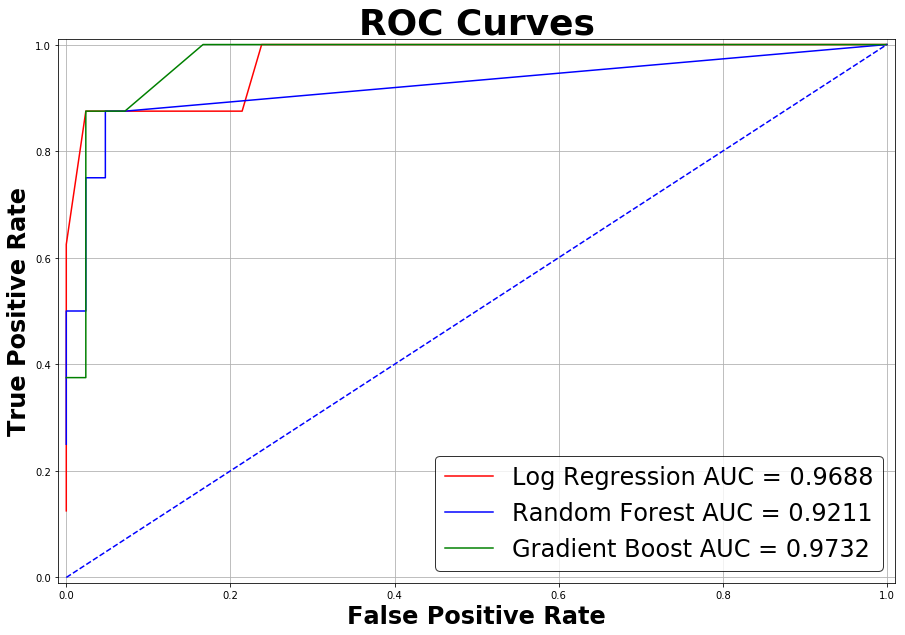

In [57]:
plt.figure(figsize=(15,10))
plt.plot(
    false_lr, true_lr, 'r',
    false_rfc, true_rfc, 'b',
    false_gbc, true_gbc, 'g',)
plt.legend(('Log Regression AUC = {}'.format(lr_auc),
           'Random Forest AUC = {}'.format(rfc_auc),
           'Gradient Boost AUC = {}'.format(gbc_auc)),
           loc = 'lower right', edgecolor='k', prop={'size': 24})
plt.plot([0, 1], [0, 1],'b--')
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.title('ROC Curves', fontweight='bold', fontsize=36)
plt.ylabel('True Positive Rate', fontweight='bold', fontsize=24)
plt.xlabel('False Positive Rate', fontweight='bold', fontsize=24)
plt.grid()
plt.show()

# Voting

In [58]:
def vote(df_list, n_highest):
    
    '''
    take list of model proba results and return voting results for n predicted states
    
    return a new df with states listed by descending voting scores
    '''
    
    scores = np.zeros((50,1))

    for proba_rank in df_list:
        for rank, state in proba_rank.iterrows():            
            if rank < n_highest:                
                # state[0] is state's actual index
                scores[state[0]]+=1
                
    
    state_scores = test['geography'].to_frame()
    state_scores['score'] = scores
    
    return state_scores.sort_values(by='score', ascending=False)

In [61]:
df_list = [df_lr_probs, df_gbc_probs, df_rfc_probs]

# with rfc max is 10
vote_results = vote(df_list, 10)
vote_results.head(10)

,geography,score
25,Montana,3.0
44,Vermont,3.0
1,Alaska,3.0
18,Maine,3.0
36,Oregon,3.0
10,Hawaii,3.0
27,Nevada,3.0
4,California,3.0
5,Colorado,3.0
46,Washington,3.0


## voting frame

In [62]:
models_df = pd.concat([df_lr_probs.sort_values(by=['lr_probability'], ascending=False),\
                    df_gbc_probs.sort_values(by=['gbc_probability'], ascending=False),\
                    df_rfc_probs.sort_values(by=['rfc_probability'], ascending=False)],\
                    axis=1)
models_df

,index,geography,lr_probability,index,geography,gbc_probability,index,geography,rfc_probability
0,4,California,0.438884,5,Colorado,0.675105,5,Colorado,1.000000
1,1,Alaska,0.379038,36,Oregon,0.675105,46,Washington,1.000000
2,46,Washington,0.379038,46,Washington,0.675105,36,Oregon,0.897535
3,36,Oregon,0.379038,44,Vermont,0.470982,4,California,0.633333
4,18,Maine,0.350327,4,California,0.411796,44,Vermont,0.560000
5,5,Colorado,0.322660,18,Maine,0.193345,1,Alaska,0.404947
6,27,Nevada,0.322660,27,Nevada,0.193345,27,Nevada,0.396947
7,10,Hawaii,0.322660,1,Alaska,0.193345,10,Hawaii,0.286000
8,44,Vermont,0.224879,10,Hawaii,0.144924,18,Maine,0.269328
9,25,Montana,0.224879,25,Montana,0.093131,25,Montana,0.027020


In [118]:
# for Flask

# model = lr.fit(X_train, y_train)
# model.predict_proba([[0.5, 0.5, 10]])

# import pickle
# muffin_cupcake_dict = {'muffin_cupcake_model': model, 'muffin_cupcake_features': ['college_ratio', 'eng_ratio', 'years_med']}
# muffin_cupcake_dict
# pickle.dump(muffin_cupcake_dict, open('/home/nate/flask_test/pkl_muffins_cupcakes.p', 'wb'))

In [59]:
lrs = list(df_lr_probs.sort_values('index')['lr_probability'])
gbcs = list(df_gbc_probs.sort_values('index')['gbc_probability'])

lr_norm = [float(x)/sum(lrs) for x in lrs]
gbc_norm = [float(x)/sum(gbcs) for x in gbcs]

probs = [(x+y)/2 for x,y in zip(lr_norm, gbc_norm)]

In [61]:
norm_df = df_16[['geography']].copy()
norm_df['norm_prob'] = probs

In [62]:
norm_df.to_csv('/home/nate/ds/metis/class_work/projects/clean_data/new_norm.csv')